In [168]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import numpy as np
import os

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('always')

### Dataset

In [2]:
device = torch.device("cuda")

BATCH_SIZE = 32

In [112]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import os
from sklearn.model_selection import train_test_split

def prepare_data(data_path='EEG_Data'):
    X = []
    Y = []
    
    for dir in os.listdir(data_path):
        folder_path = os.path.join(data_path, dir)
        dirs = os.listdir(folder_path)
        
        print(f'Number of samples in class {dir}: {len(dirs)}')
        
        for file in dirs:
            file_path = os.path.join(folder_path, file)
            spectrogram = np.load(file_path)
            X.append(spectrogram)
            Y.append(int(dir))

    X = np.array(X)
    X = np.array([((x - x.mean()) / (x.std() + 1e-8)) for x in X])
    Y = np.array(Y)
    X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42, stratify=y_temp)
    
    print("Class distribution before SMOTE:", Counter(y_train))
    
    original_shape = X_train.shape
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)
    
    sampling_strategy = {
        class_label: max(700, count) for class_label, count in Counter(y_train).items()
    }
    
    smote = SMOTE(
        random_state=42,
        k_neighbors=min(5, min(Counter(y_train).values()) - 1),
        sampling_strategy=sampling_strategy
    )
    
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flattened, y_train)
    X_train_resampled = X_train_resampled.reshape(-1, original_shape[1], original_shape[2])
    
    print("\nClass distribution after SMOTE:", Counter(y_train_resampled))
    
    return X_train, X_train_resampled, X_val, X_test, y_train, y_train_resampled, y_val, y_test

X_train, X_train_resampled, X_val, X_test, y_train, y_train_resampled, y_val, y_test = prepare_data()


Number of samples in class 0: 2906
Number of samples in class 1: 237
Number of samples in class 2: 1755
Number of samples in class 3: 497
Number of samples in class 4: 418
Class distribution before SMOTE: Counter({0: 2004, 2: 1224, 3: 374, 4: 298, 1: 169})

Class distribution after SMOTE: Counter({0: 2004, 2: 1224, 3: 700, 4: 700, 1: 700})


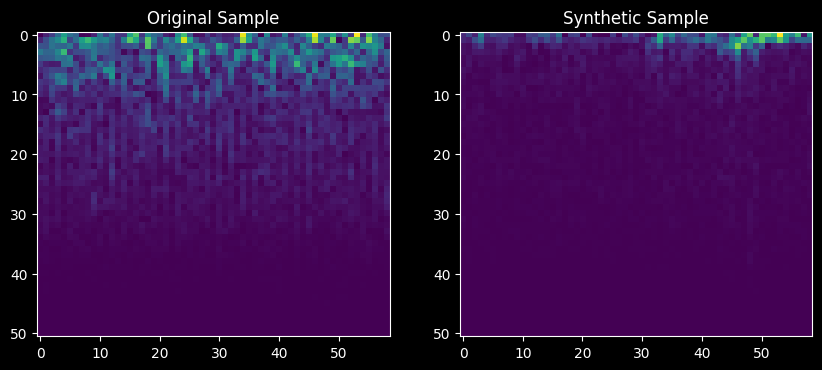

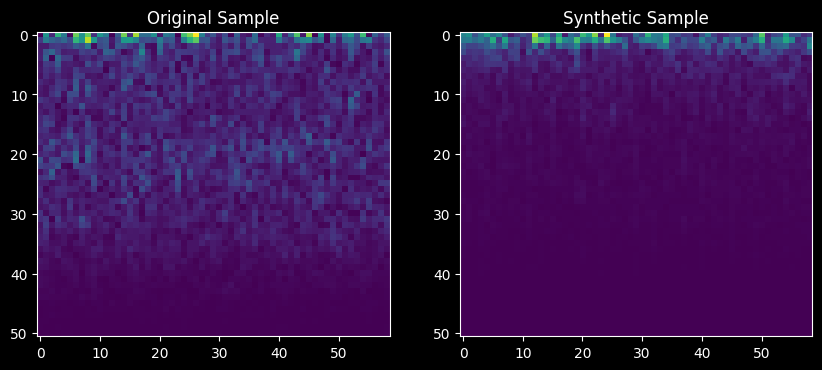

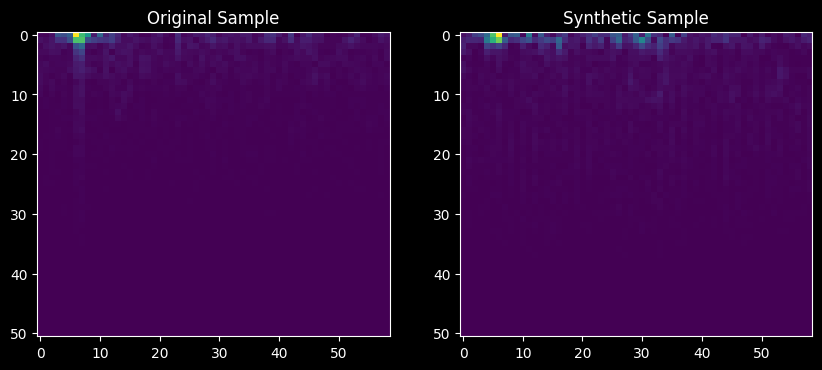

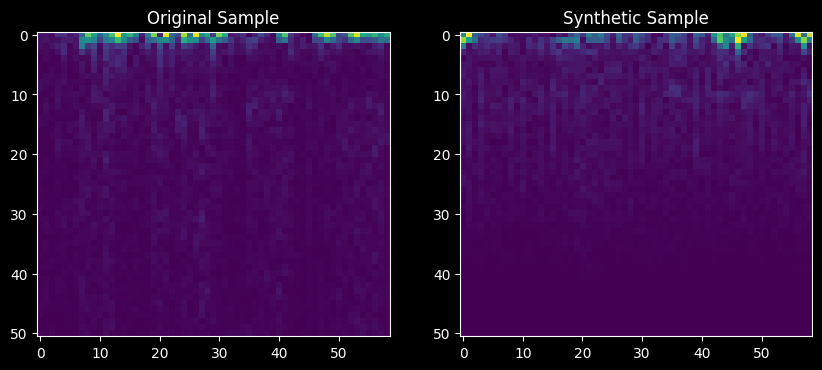

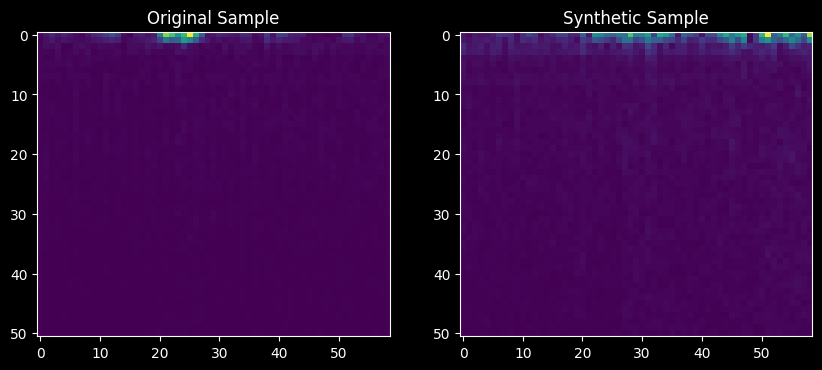

In [142]:
def plot_sample_comparison(original_X, resampled_X, original_y, resampled_y, class_idx):
    orig_idx = np.where(original_y == class_idx)[0][0]
    resamp_idx = np.where(resampled_y == class_idx)[0][-1] 
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(original_X[orig_idx])
    ax1.set_title('Original Sample')
    
    ax2.imshow(resampled_X[resamp_idx])
    ax2.set_title('Synthetic Sample')
    
    plt.show()


for i in range(5):
    plot_sample_comparison(X_train, X_train_resampled, y_train, y_train_resampled, class_idx=i)

In [113]:
class EEG_Dataset(Dataset):
    def __init__(self, X, Y):
        
        self.X = X
        self.Y = Y
        self.X = torch.FloatTensor(X)
        self.Y = torch.LongTensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].squeeze()
        x = x.unsqueeze(0)
        return x.to(device), self.Y[idx].to(device)

In [115]:
train_dataset = EEG_Dataset(X_train_resampled, y_train_resampled)
val_dataset = EEG_Dataset(X_val, y_val)
test_dataset = EEG_Dataset(X_test, y_test)

In [116]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Model

In [144]:
class SpectrogramCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 6 * 7, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)
        
        self.fc_final = nn.Linear(256, 5) 
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 64 * 6 * 7) 
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn5(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc_final(x)
        return x


In [174]:
model = SpectrogramCNN().to(device)
# xx1 = train_dataset[0][0].unsqueeze(0)
# xx2 = train_dataset[1][0].unsqueeze(0)
# xx = torch.cat((xx1, xx2), dim=0)
# xx.shape
# yy = torch.cat((train_dataset[0][1].unsqueeze(0), train_dataset[1][1].unsqueeze(0)), dim=0)

In [175]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

In [176]:
total_samples = sum([2004, 700, 1224, 700, 700])
class_weights = torch.FloatTensor([
    total_samples/(5 * 2906),  
    total_samples/(5 * 237),   
    total_samples/(5 * 1755),  
    total_samples/(5 * 497),   
    total_samples/(5 * 418)    
]).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [177]:
n_epochs = 100

losses = []
val_acc = []
val_precision = []
val_recall = []
val_f1 = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)

        optimizer.zero_grad()
        loss = loss_fn(outputs, y_batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        losses.append(train_loss / len(train_loader))
        val_acc.append(100 * correct / total)
        val_precision.append(precision)
        val_recall.append(recall)
        val_f1.append(f1)

    if epoch % 20 == 0 or epoch + 1 == n_epochs:
        print(f'Epoch {epoch+1}/{n_epochs}')
        print(f'Training Loss: {train_loss/len(train_loader):.4f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        print(f'Accuracy: {100 * correct / total:.2f}% Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Epoch 1/100
Training Loss: 1.5379
Validation Loss: 1.8127
Accuracy: 9.61% Precision: 0.3384, Recall: 0.0961, F1 Score: 0.1017


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21/100
Training Loss: 0.4755
Validation Loss: 2.9207
Accuracy: 11.76% Precision: 0.4041, Recall: 0.1176, F1 Score: 0.1149
Epoch 41/100
Training Loss: 0.2778
Validation Loss: 3.9546
Accuracy: 14.63% Precision: 0.3854, Recall: 0.1463, F1 Score: 0.1743
Epoch 61/100
Training Loss: 0.2214
Validation Loss: 4.2638
Accuracy: 23.39% Precision: 0.3584, Recall: 0.2339, F1 Score: 0.2714
Epoch 81/100
Training Loss: 0.2465
Validation Loss: 3.9075
Accuracy: 20.80% Precision: 0.3709, Recall: 0.2080, F1 Score: 0.2548


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100
Training Loss: 0.2021
Validation Loss: 3.8779
Accuracy: 32.57% Precision: 0.3967, Recall: 0.3257, F1 Score: 0.3443


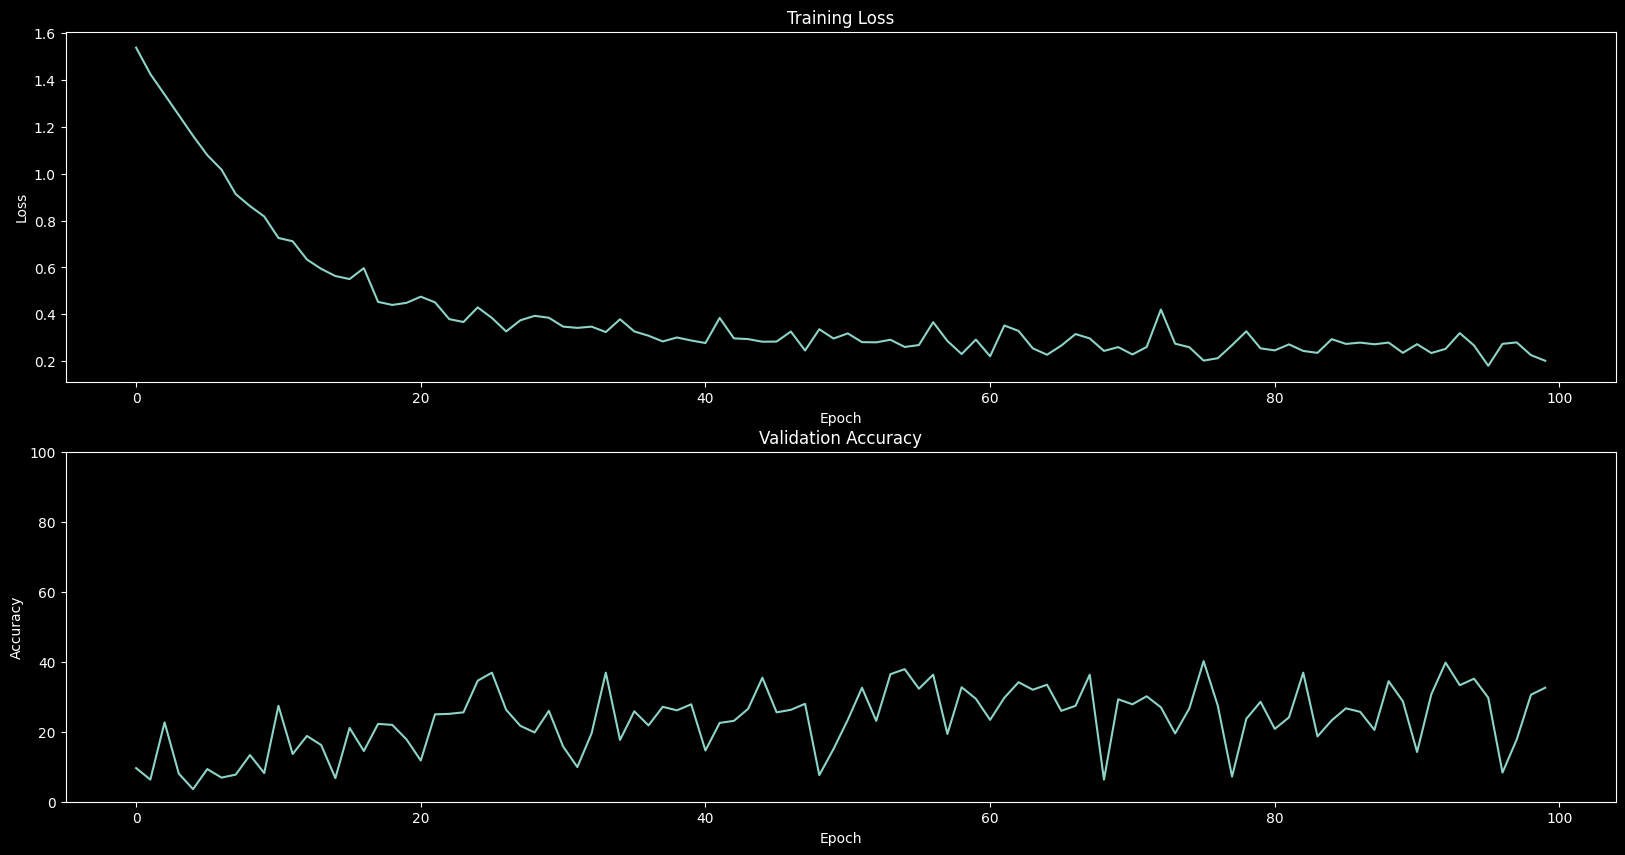

In [178]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(val_acc)
plt.ylim(0, 100)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()